In [8]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib as plt
from sklearn.svm import SVC

In [7]:
import joblib
import io
import pickle
import pprint
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from azure.storage.blob import BlobServiceClient
from azure.storage.blob import BlobClient
from azure.storage.blob import BlobClient, ContainerClient
import logging
logging.basicConfig(level=logging.INFO)

In [6]:
model = joblib.load(r"testingmodel.pkl")

In [14]:
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobClient

# Set your storage details
account_url = "https://churnprediction1.blob.core.windows.net"
container_name = "test-upload"
blob_name = "test_pkl.pkl"
file_path = "testingmodel.pkl"

# Auth using default credentials (VS Code, CLI, Managed Identity, etc.)
credential = DefaultAzureCredential()

# Create the blob client
blob_client = BlobClient(
    account_url=account_url,
    container_name=container_name,
    blob_name=blob_name,
    credential=credential
)

# Upload the file with concurrency for speed
with open(file_path, "rb") as data:
    blob_client.upload_blob(data, overwrite=True, max_concurrency=108)  # Try 8, 16, or 32


INFO:azure.identity._credentials.environment:No environment configuration found.
INFO:azure.identity._credentials.managed_identity:ManagedIdentityCredential will use IMDS
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'http://169.254.169.254/metadata/identity/oauth2/token?api-version=REDACTED&resource=REDACTED'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.23.0 Python/3.11.0 (Windows-10-10.0.19045-SP0)'
No body was attached to the request
INFO:azure.identity._credentials.chained:DefaultAzureCredential acquired a token from AzureCliCredential
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://churnprediction1.blob.core.windows.net/test-upload/test_pkl.pkl'
Request method: 'PUT'
Request headers:
    'Content-Length': '3500687'
    'x-ms-blob-type': 'REDACTED'
    'x-ms-version': 'REDACTED'
    'Content-Type': 'application/octet-stream'
    'Accept': 'application/xml'
    'User-Agent': 'azsdk-python-storage-b

In [9]:
df = pd.read_csv(r"customer_churn_dataset-testing-master.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'customer_churn_dataset-testing-master.csv'

In [4]:
df.shape

(64374, 12)

<Axes: xlabel='Churn', ylabel='count'>

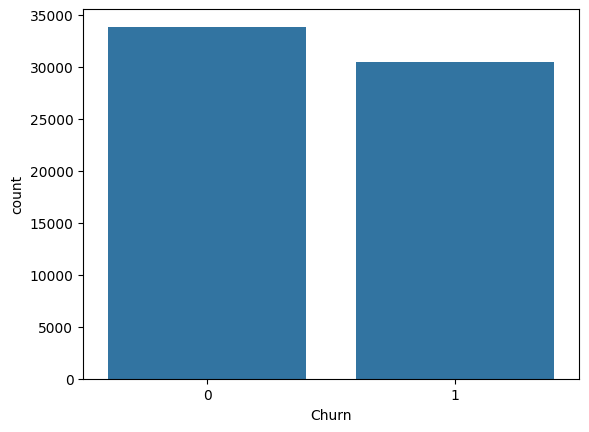

In [5]:
sns.countplot(x=df['Churn'])

In [7]:
df = pd.read_csv("D:\Azure MLOps learning\Custom project\customer churn prediction\pracitce\customer_churn1.csv")  # or your existing DataFrame
df.shape

(21243, 12)

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assume you already have this
df = pd.read_csv("D:\Azure MLOps learning\Custom project\customer churn prediction\pracitce\customer_churn1.csv")  # or your existing DataFrame
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Step 1: Stratified split into train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.67, stratify=y, random_state=42
)

# Step 2: Stratified split temp into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Combine features and target back
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Save to CSV
train_df.to_csv("customer_churn1.csv", index=False)
val_df.to_csv("customer_churn2.csv", index=False)
test_df.to_csv("customer_churn3.csv", index=False)


In [10]:
paths = ["D:\Azure MLOps learning\Custom project\customer churn prediction\customer_churn3.csv", "D:\Azure MLOps learning\Custom project\customer churn prediction\customer_churn1.csv", "D:\Azure MLOps learning\Custom project\customer churn prediction\customer_churn2.csv"]

In [11]:
for pat in paths: 
    df = pd.read_csv(pat)
    print(pat, df.shape)
    print(df['Churn'].value_counts())
    

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Azure MLOps learning\\Custom project\\customer churn prediction\\customer_churn3.csv'

In [12]:
100/3

33.333333333333336

In [13]:
100-33

67

In [22]:
64374/3

21458.0

In [12]:
def train_model(data, pass_validation, base_line, store_model, meta):
    """----Train----"""

    x_train, x_test, y_train, y_test = data
    pipe = Pipeline(steps=[
        ("Scale", StandardScaler()), 
        ("Train", ExtraTreesClassifier(
            n_estimators=500, \
            n_jobs=-1, random_state=39))
    ])
    pipe.fit(x_train, y_train)
    logging.info("Training Complete")

    """----Validate----"""

    scores = {}
    y_pred = pipe.predict(x_test)
    metricses = [accuracy_score, f1_score, precision_score, \
                  roc_auc_score, recall_score]
    for metric_ in metricses: 
        namen = metric_.__name__
        score = metric_(y_test, y_pred)
        scores[namen]=score
    
    pprint.pprint(scores)

    # baseline_accuracy = 0.70
    baseline_accuracy = base_line/100
    if pass_validation: 
        if store_model: 
            meta['scores']=scores
            store_model_blob(pipe)
        else: 
            logging.info("Passed validatoin and model is not stored.")
    else:
        if store_model:
            if scores['accuracy_score']>= baseline_accuracy:
                logging.info(f"Model got approved and being stored-✔ |BaseLine {baseline_accuracy}| Accuracy: {scores['accuracy_score']*100:.0f}%")
                meta['scores']=scores
                store_model_blob(pipe)
            else: 
                logging.info(f"Model got disapproved-❌|BaseLine {baseline_accuracy} | Accuracy: {scores['accuracy_score']*100:.0f}%")
        else:
            if scores['accuracy_score']>= baseline_accuracy:
                logging.info(f"Model got approved and not stored-✔|BaseLine {baseline_accuracy} | Accuracy: {scores['accuracy_score']*100:.0f}%")
            else: 
                logging.info(f"Model got disapproved-❌|BaseLine {baseline_accuracy}| Accuracy: {scores['accuracy_score']*100:.0f}%")


In [20]:
df = pd.read_csv(r"customer_churn2.csv")
x_train, y_train = df.drop(columns=['Churn', 'CustomerID']), df['Churn']

In [14]:
x_train.isna().sum()

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
dtype: int64

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier

class Preprocess(BaseEstimator, TransformerMixin): 
    def fit(self, x, y=None):
        return self

    def transform(self,x):
        x = x.copy()

        enc_gend = {"Male":0, "Female":1}
        x_train['Gender'] = x_train['Gender'].map(enc_gend)

        enc_sub = {'Premium':2, 'Standard':1, 'Basic':0}
        x_train['Subscription Type'] = x_train['Subscription Type'].map(enc_sub)

        enc_cont = {'Monthly':0, 'Quarterly':1, 'Annual':2}
        x_train['Contract Length'] = x_train['Contract Length'].map(enc_cont)

        return x

In [21]:
from sklearn.pipeline import Pipeline
import joblib

# def preprocess(x_train, y_train):
#     x_train = x_train.copy()
#     enc_gend = {"Male":0, "Female":1}
#     x_train['Gender'] = x_train['Gender'].map(enc_gend)

#     enc_sub = {'Premium':2, 'Standard':1, 'Basic':0}
#     x_train['Subscription Type'] = x_train['Subscription Type'].map(enc_sub)

#     enc_cont = {'Monthly':0, 'Quarterly':1, 'Annual':2}
#     x_train['Contract Length'] = x_train['Contract Length'].map(enc_cont)

#     return x_train, y_train

pipe = Pipeline(steps=[
    ("Preprocess", Preprocess()), 
    ("Train", ExtraTreesClassifier(
        n_estimators=100, \
        n_jobs=-1, random_state=39))
])

In [22]:
x_train

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
0,33,Male,19,13,5,14,Basic,Quarterly,428,6
1,21,Female,9,12,4,10,Basic,Annual,463,11
2,43,Male,20,18,2,15,Premium,Annual,658,14
3,24,Female,30,12,5,7,Standard,Quarterly,375,6
4,29,Female,5,2,0,0,Basic,Monthly,372,22
...,...,...,...,...,...,...,...,...,...,...
7111,50,Female,17,5,8,25,Basic,Quarterly,745,2
7112,65,Female,15,2,9,13,Premium,Annual,966,22
7113,57,Female,55,5,8,7,Basic,Quarterly,236,11
7114,63,Male,53,6,8,18,Premium,Monthly,670,11


In [24]:
pipe.fit(x_train, y_train)

joblib.dump(pipe, "pipe.pkl")

['pipe.pkl']

In [76]:
model = joblib.load('pipe.pkl')

In [78]:
model.predict(x_t)

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [6]:
import json
import pandas as pd

df = pd.read_csv(r"customer_churn2.csv")
records = df.to_dict(orient='records')

In [9]:
with open("sample.json", 'w') as f:
    json.dump({"data":records}, f, indent=4)

In [4]:
data = {}

for k,v in df.head().to_dict()
    data["data"] = { 
        for k_, v_ in v.items()
    }

{'CustomerID': {0: 28257, 1: 34183, 2: 14372, 3: 22769, 4: 25933},
 'Age': {0: 33, 1: 21, 2: 43, 3: 24, 4: 29},
 'Gender': {0: 'Male', 1: 'Female', 2: 'Male', 3: 'Female', 4: 'Female'},
 'Tenure': {0: 19, 1: 9, 2: 20, 3: 30, 4: 5},
 'Usage Frequency': {0: 13, 1: 12, 2: 18, 3: 12, 4: 2},
 'Support Calls': {0: 5, 1: 4, 2: 2, 3: 5, 4: 0},
 'Payment Delay': {0: 14, 1: 10, 2: 15, 3: 7, 4: 0},
 'Subscription Type': {0: 'Basic',
  1: 'Basic',
  2: 'Premium',
  3: 'Standard',
  4: 'Basic'},
 'Contract Length': {0: 'Quarterly',
  1: 'Annual',
  2: 'Annual',
  3: 'Quarterly',
  4: 'Monthly'},
 'Total Spend': {0: 428, 1: 463, 2: 658, 3: 375, 4: 372},
 'Last Interaction': {0: 6, 1: 11, 2: 14, 3: 6, 4: 22},
 'Churn': {0: 0, 1: 0, 2: 0, 3: 0, 4: 1}}

In [1]:
import json

In [3]:
with open(r"Alldatasets/sample.json", "rb") as f:
    data = json.load(f)

In [6]:
for i in data['data']:
    del i['Churn']

In [10]:
with open(r"Alldatasets/sample.json", "w") as f: 
    json.dump(data, f, indent=4)

In [11]:
len(data['data'])

7116

In [ ]:
{'accuracy_score': 0.994943820224719, 'f1_score': 0.9946396664681358, 'precision_score': 0.9988038277511961, 'roc_auc_score': 0.9947214235888244, 'recall_score': 0.9905100830367735}

Data Drift Calculation: 

In [3]:
import json
import io 
import pandas as pd 
from azure.storage.blob import BlobServiceClient
from azure.identity import DefaultAzureCredential
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
import os 
from datetime import datetime, timedelta
import logging
import tempfile
logging.basicConfig(level=logging.INFO, format="%(asctime)s \
                    - %(levelname)s - %(message)s")


In [6]:


def detect_save_extract_drift(storage_account, train_container, current_data_container):
    
    def read_data(container_name, blob_service_client):
        container_client = blob_service_client.get_container_client(container_name)

        blobs = container_client.list_blobs()
        latest_blob = max(blobs, key=lambda b:b.last_modified)
        blob_client = container_client.get_blob_client(latest_blob.name)
        blob_data = blob_client.download_blob().readall()

        df = pd.read_csv(io.StringIO(blob_data.decode("utf-8")), sep=",")
        return df, container_client

    def load_both_data():
            try:
                credential = DefaultAzureCredential()

                account_url = f"https://{storage_account}.blob.core.windows.net"
                blob_service_client = BlobServiceClient(account_url=account_url, credential=credential)
                
                reference_data, _ = read_data(train_container, blob_service_client)
                current_data, current_blob_client = read_data(current_data_container, blob_service_client)

                # reference_data.drop(columns=['Potability'], inplace=True)
                # current_data['timestamp'] = pd.to_datetime(current_data['timestamp'])
                # one_week_ago = datetime.utcnow()-timedelta(days=7)
                # current_data_last_week = current_data[current_data['timestamp']>=one_week_ago]
                logging.info(f'Total # Current Data {len(current_data)}\n Total # Reference Data {len(reference_data)}')

                # current_data_last_week.drop(columns=['timestamp', 'prediction'], inplace=True)
                return reference_data, current_data, blob_service_client, current_data_container
                
            except Exception as e: 
                logging.error(f"Error loading data : {e}")
                return None, None, None, None

    def get_drift_report(referenceData, currentData, blob_service_client, current_data_container):
        report = Report(metrics=[DataDriftPreset()])
        report.run(reference_data=referenceData, current_data=currentData)

        tmp_dir = tempfile.gettempdir()
        tmp_file_path = os.path.join(tmp_dir, "drift_report.html")
        report.save_html(tmp_file_path)

        container_client = blob_service_client.get_container_client("drift-report")
        try: 
            container_client.create_container()
        except Exception: 
            logging.info("Report container Already exists")

        report_blob_client = container_client.get_blob_client("datadriftreport.html")


        with open(tmp_file_path, "rb") as f:
            print(f"{f = }")
            # report_blob_path = "reports/drift_report.html"
            # report_blob = report_blob_client.get_blob_client(container="Drift-report", blob=report_blob_path)
            report_blob_client.upload_blob(f.read(), overwrite=True)

        drift_results = report.as_dict()
        # drift_score = drift_results['metrics'][0]['result']['drift_share']
        # logging.info(f"Drift Score: {drift_score}......")
        # return drift_score
        return drift_results

    def extract_score_result(full_metric):
        drift_by_column = []
        for k, v in full_metric['metrics'][1]['result']['drift_by_columns'].items():
            # print(f"Column: {k} --- Score: {v['drift_score']} --- IsDrift: {v['drift_detected']}")
            drift_by_column.append({k:{"Score":v['drift_score'], "IsDrift":v['drift_detected']}})   
        return drift_by_column

    def main():
        logging.info("Loading current and reference data...")
        reference, target, blob_service_client, current_container = load_both_data()
        if reference is None or target is None: 
            logging.error("Data Loading failed. Skipping drift detection❌")
            return
        logging.info("Determining Drift ")
        full_drift_metrices = get_drift_report(reference, target, blob_service_client, current_container)

        # if drift_value>0.1:
        #     logging.info(f"Drift is high... Retraining Needed ❗❗❗ {drift_value}")
        #     trigger_azure_pipeline()
        # else: 
        #     logging.info("Drift is tolerable... No need for retraining 🔹")
        dirft_score_column = extract_score_result(full_drift_metrices)

        return dirft_score_column, full_drift_metrices
    return main()
 

In [7]:
score_by_column , stats = detect_save_extract_drift("churnprediction1", "training-data", "retraining-data")

2025-07-14 19:32:58,092                     - INFO - Loading current and reference data...
2025-07-14 19:32:58,093                     - INFO - No environment configuration found.
2025-07-14 19:32:58,094                     - INFO - ManagedIdentityCredential will use IMDS
2025-07-14 19:32:58,095                     - INFO - Request URL: 'http://169.254.169.254/metadata/identity/oauth2/token?api-version=REDACTED&resource=REDACTED'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.23.0 Python/3.11.0 (Windows-10-10.0.19045-SP0)'
No body was attached to the request
2025-07-14 19:32:58,975                     - INFO - DefaultAzureCredential acquired a token from AzureCliCredential
2025-07-14 19:32:58,976                     - INFO - Request URL: 'https://churnprediction1.blob.core.windows.net/training-data?restype=REDACTED&comp=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'User-Agent': 'az

f = <_io.BufferedReader name='C:\\Users\\CIPL1513\\AppData\\Local\\Temp\\drift_report.html'>


2025-07-14 19:33:11,808                     - INFO - Response status: 201
Response headers:
    'Content-Length': '0'
    'Content-MD5': 'REDACTED'
    'Last-Modified': 'Mon, 14 Jul 2025 14:03:12 GMT'
    'ETag': '"0x8DDC2DF2BB6D5BC"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': '3fecd0ef-c01e-0008-48c8-f49f41000000'
    'x-ms-client-request-id': '43e5b545-60bb-11f0-aa9f-f46b8cd0b72e'
    'x-ms-version': 'REDACTED'
    'x-ms-content-crc64': 'REDACTED'
    'x-ms-request-server-encrypted': 'REDACTED'
    'x-ms-version-id': 'REDACTED'
    'Date': 'Mon, 14 Jul 2025 14:03:12 GMT'


In [2]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

def get_feature_importance(model, X, y, n_repeats=10, random_state=42, scoring=None):
    
    """
    Extract feature importance from any sklearn supervised model.

    Parameters:
    - model: fitted sklearn estimator
    - X: pd.DataFrame or np.ndarray, feature matrix used for evaluation
    - y: array-like, target vector
    - n_repeats: int, number of repeats for permutation importance (default=10)
    - random_state: int, random seed for permutation importance
    - scoring: str or callable, scoring metric for permutation importance (default=None uses model.score)

    Returns:
    - pd.DataFrame with columns: ['feature', 'importance_mean', 'importance_std']
      sorted by descending importance_mean
    """

    # Get feature names if possible
    if hasattr(X, 'columns'):
        feature_names = X.columns
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]

    # Case 1: Tree-based models with feature_importances_
    if hasattr(model, 'feature_importances_'):
        logging.info("Given model tree based...")
        importances = model.feature_importances_
        df = pd.DataFrame({
            'feature': feature_names,
            'importance_mean': importances,
            'importance_std': np.zeros_like(importances)
        })
        df = df.sort_values(by='importance_mean', ascending=False)
        return df.reset_index(drop=True)

    # Case 2: Linear models with coef_
    elif hasattr(model, 'coef_'):
        # coef_ can be 1D or 2D (multi-class)
        logging.info("Given model is linear model...")

        coefs = model.coef_
        if coefs.ndim == 1:
            importances = np.abs(coefs)
        else:
            # For multi-class, take mean absolute coef across classes
            importances = np.mean(np.abs(coefs), axis=0)
        df = pd.DataFrame({
            'feature': feature_names,
            'importance_mean': importances,
            'importance_std': np.zeros_like(importances)
        })
        df = df.sort_values(by='importance_mean', ascending=False)
        return df.reset_index(drop=True)

    # Case 3: Use permutation importance (model-agnostic)
    else:
        logging.info("Given model agnostic...")

        # Run permutation importance on given data
        perm_result = permutation_importance(
            model, X, y,
            n_repeats=n_repeats,
            random_state=random_state,
            scoring=scoring
        )
        df = pd.DataFrame({
            'feature': feature_names,
            'importance_mean': perm_result.importances_mean,
            'importance_std': perm_result.importances_std
        })
        df = df.sort_values(by='importance_mean', ascending=False)
        return df.reset_index(drop=True)


In [1]:
import logging.config
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.base import BaseEstimator, TransformerMixin

from preprocessing import Preprocess

import io
import pickle
import pprint
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
from azure.storage.blob import BlobServiceClient
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score
import argparse
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s \
                    - %(levelname)s - %(message)s")


# def str2bool(v):
#     return str(v).lower() in ("true", "1", "yes", "t")

# def get_args():
#     parse = argparse.ArgumentParser()

#     PassValidation=False
#     BaseLine=69
#     DataContainer="retraining-data"
#     TrainingDataContainer="training-data"
#     ModelContainer="retrained-models"
#     StoreModel=True
#     SelectLatestData=False
#     StorageAccount="churnprediction1"

#     args = parse.parse_args()
#     return args

def read_data():
    """----Read the data----"""

    credential = DefaultAzureCredential()
    # storage_account = "churnprediction1"
    # container_name = "training-data"
    container_name = data_container

    account_url = f"https://{storage_account}.blob.core.windows.net"

    blob_service_client = BlobServiceClient(account_url=account_url \
                                            , credential=credential)

    container_client = blob_service_client.get_container_client(container_name)

    if select_latest_data: 
        logging.info("Getting latest data >>>")
        blobs = container_client.list_blobs()
        latest_blob = max(blobs, key=lambda b:b.last_modified)
        blob_client = container_client.get_blob_client(latest_blob.name)
        blob_data = blob_client.download_blob().readall()
    else:
        blob_name = "customer_churn.csv"
        logging.info(f"Getting defined client {blob_name}>>>")
        blob_client = container_client.get_blob_client(blob_name)

        blob_data = blob_client.download_blob().readall()
    df = pd.read_csv(io.StringIO(blob_data.decode("utf-8")), sep=",")
    return df


def split_data(data):
    """----Split the data----"""

    X = data.drop(columns=['Churn'], axis=1)
    y = data['Churn']
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, random_state=87, \
                         shuffle=True, stratify=y)
    return X_train, X_test, y_train, y_test

def store_model_blob(pipe, meta):
    credential = DefaultAzureCredential()

    # storage_account = "churnprediction1"
    # model_container_name = "trained-models"

    account_url = f"https://{storage_account}.blob.core.windows.net"
    blob_service_client = BlobServiceClient(account_url=account_url, credential=credential)

    container_client = blob_service_client.get_container_client(model_container_name)
    try: 
        container_client.create_container()
    except Exception as e: 
        logging.info(f"Container already exists.")

    blob_name = "churn_classififer.pkl"
    blob_client = container_client.get_blob_client(blob_name)

    model_bytes = pickle.dumps(pipe)
    blob_client.upload_blob(model_bytes, overwrite=True, metadata=meta)

    logging.info(f'fininshed uploading')
    logging.info("Model training uploading completed !!!")


def train_model(data, meta):
    """----Train----"""

    x_train, x_test, y_train, y_test = data
    pipe = Pipeline(steps=[
        ("Preprocess", Preprocess()), 
        ("Train", RandomForestClassifier(
            n_estimators=125, \
            n_jobs=-1, random_state=39))
    ])
    pipe.fit(x_train, y_train)
    logging.info("Training Complete")

    """----Validate----"""

    scores = {}
    y_pred = pipe.predict(x_test)
    metricses = [accuracy_score, f1_score, precision_score, \
                  roc_auc_score, recall_score]
    for metric_ in metricses: 
        namen = metric_.__name__
        score = metric_(y_test, y_pred)
        scores[namen]=score
    
    pprint.pprint(scores)

    return pipe, scores

def store(pipe, meta, scores):
    meta['scores']=str([(k,v) for k,v in scores.items()])

    if pass_validation: 
        if store_model: 
            store_model_blob(pipe, meta)
    else:

        if store_model:
                logging.info(f"Model got approved and being stored-✔ | Accuracy: {scores['accuracy_score']*100:.0f}%")
                # meta['scores']=scores
                store_model_blob(pipe, meta)
        else:
                logging.info(f"Model got approved and not stored-✔ | Accuracy: {scores['accuracy_score']*100:.0f}%")


def is_model_okay(scores):
    base_accuracy = base_line/100
    if scores['accuracy_score']<base_accuracy:
        # logging.info("Model's accuracy is not enough- Look up is needed!!!")
        return False
    else: 
        # logging.info("Model's accuracy is enough so deployment is next...")
        return True
    

def main():
    # logging.info("Parsing Args >>>")
    # args = get_args()

    global pass_validation
    global base_line
    global data_container
    global store_model
    global select_latest_data
    global storage_account
    global model_container_name
    global training_container

    pass_validation=False
    base_line=69
    data_container="retraining-data"
    training_container="training-data"
    model_container_name="retrained-models"
    store_model=True
    select_latest_data=False
    storage_account="churnprediction1"




    meta_data = {
        "base_line":str(base_line), 
        "pass_validation":str(pass_validation), 
        "data_container":str(data_container), 
        "store_model":str(store_model), 
        "select_latest_data":str(select_latest_data)
    }   

    logging.info(f"-------Given Args-------: \n \
                {pass_validation = }\n \
                {base_line = }\n \
                {data_container = }\n \
                {store_model = }\n \
                {select_latest_data = }\n------------------------------------")

    logging.info("Provisioning Data >>>")
    df = read_data()
    print(df.head())

    logging.info("Splitting data >>>")
    X_train, X_test, y_train, y_test = split_data(df)

    logging.info("Training Model >>>")
    pipe, scores = train_model([X_train, X_test, y_train, y_test], meta_data)
    return pipe, X_train, y_train

In [2]:
model, X_train, y_train = main()

2025-07-15 13:40:36,366                     - INFO - -------Given Args-------: 
                 pass_validation = False
                 base_line = 69
                 data_container = 'retraining-data'
                 store_model = True
                 select_latest_data = False
------------------------------------
2025-07-15 13:40:36,366                     - INFO - Provisioning Data >>>
2025-07-15 13:40:36,366                     - INFO - No environment configuration found.
2025-07-15 13:40:36,366                     - INFO - ManagedIdentityCredential will use IMDS
2025-07-15 13:40:36,366                     - INFO - Getting defined client customer_churn.csv>>>
2025-07-15 13:40:36,377                     - INFO - Request URL: 'http://169.254.169.254/metadata/identity/oauth2/token?api-version=REDACTED&resource=REDACTED'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.23.0 Python/3.11.0 (Windows-10-10.0.19045-SP0)'
No body was attached to the requ

   CustomerID  Age  Gender  Tenure  Usage Frequency  Support Calls  \
0       57745   27  Female      37                2              2   
1       38580   63  Female      60               22              8   
2       22310   62  Female       3               11              6   
3       55150   29  Female      55               17              3   
4       25238   50  Female      30               22              5   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0             19          Standard          Annual          121   
1             28          Standard         Monthly          431   
2             27          Standard          Annual          821   
3             26             Basic         Monthly          486   
4              9             Basic          Annual          895   

   Last Interaction  Churn  
0                15      1  
1                26      1  
2                23      0  
3                20      1  
4                 6      0  
{'

In [13]:
model.named_steps['Train'].feature_importances_

array([0.2737166 , 0.02742302, 0.04627007, 0.08886616, 0.05698054,
       0.13083376, 0.3057905 , 0.00447131, 0.01718311, 0.03726177,
       0.01120317])

In [26]:
importance = get_feature_importance(model, X_train, y_train)

2025-07-14 19:45:54,662                     - INFO - Given model agnostic...


In [31]:
print(importance)
significant_features = list(importance[importance['importance_mean']>0.01]['feature'].values)


              feature  importance_mean  importance_std
0       Payment Delay         0.180214        0.004568
1          CustomerID         0.154281        0.002978
2       Support Calls         0.099176        0.002866
3              Tenure         0.066892        0.002732
4              Gender         0.046374        0.002001
5     Usage Frequency         0.035076        0.001228
6         Total Spend         0.026120        0.001796
7     Contract Length         0.018718        0.001081
8                 Age         0.017782        0.000942
9    Last Interaction         0.000094        0.000094
10  Subscription Type         0.000000        0.000000


In [44]:


significant_features_drift = []
for i in score_by_column: 
    feature = list(i.keys())[0]
    if feature in significant_features: 
        significant_features_drift.append((feature, i[feature]['Score']))


In [46]:
score_by_column

[{'Age': {'Score': 0.00819256479387201, 'IsDrift': False}},
 {'Churn': {'Score': 5.156603350722112e-06, 'IsDrift': False}},
 {'CustomerID': {'Score': 0.017642036425937892, 'IsDrift': False}},
 {'Last Interaction': {'Score': 0.008019276519460564, 'IsDrift': False}},
 {'Payment Delay': {'Score': 0.007119867989377113, 'IsDrift': False}},
 {'Support Calls': {'Score': 0.009868452062614665, 'IsDrift': False}},
 {'Tenure': {'Score': 0.01237836000057771, 'IsDrift': False}},
 {'Total Spend': {'Score': 0.011779732467089514, 'IsDrift': False}},
 {'Usage Frequency': {'Score': 0.010718266354587102, 'IsDrift': False}},
 {'Contract Length': {'Score': 0.0031085439588928792, 'IsDrift': False}},
 {'Gender': {'Score': 0.0027070195992604457, 'IsDrift': False}},
 {'Subscription Type': {'Score': 0.006623968005126058, 'IsDrift': False}}]

In [48]:
significant_features_drift

[('Age', 0.00819256479387201),
 ('CustomerID', 0.017642036425937892),
 ('Payment Delay', 0.007119867989377113),
 ('Support Calls', 0.009868452062614665),
 ('Tenure', 0.01237836000057771),
 ('Total Spend', 0.011779732467089514),
 ('Usage Frequency', 0.010718266354587102),
 ('Contract Length', 0.0031085439588928792),
 ('Gender', 0.0027070195992604457)]

In [51]:
def get_significant_features_drift(importance, drift):
    significant_features = list(importance[importance['importance_mean']>0.01]['feature'].values)    
    
    significant_features_drift = []
    for i in drift: 
        feature = list(i.keys())[0]
        if feature in significant_features: 
            significant_features_drift.append((feature, i[feature]['Score']))
    return significant_features_drift    

In [19]:
importance = get_feature_importance(model.named_steps['Train'], X_train, y_train)
importance

2025-07-14 19:34:15,416                     - INFO - Given model tree based...


,feature,importance_mean,importance_std
0,Payment Delay,0.305791,0.0
1,CustomerID,0.273717,0.0
2,Support Calls,0.130834,0.0
3,Tenure,0.088866,0.0
4,Usage Frequency,0.056981,0.0
5,Gender,0.046270,0.0
6,Total Spend,0.037262,0.0
7,Age,0.027423,0.0
8,Contract Length,0.017183,0.0
9,Last Interaction,0.011203,0.0


In [24]:
importance.columns

Index(['feature', 'importance_mean', 'importance_std'], dtype='object')

ImportError: cannot import name 'get_columns_based_on_type' from 'drift_importance' (d:\Azure MLOps learning\Custom project\customer churn prediction\pracitce\Handiling Drift\drift_importance.py)

In [3]:
from drift_importance import detect_save_extract_drift, get_feature_importance, get_significant_features_drift, get_columns_based_on_type
score_by_column , stats = detect_save_extract_drift("churnprediction1", "training-data", "retraining-data")

importance = get_feature_importance(model.named_steps['Train'], X_train, y_train)

sig_drift = get_significant_features_drift(importance, score_by_column)


2025-07-15 13:40:44,178                     - INFO - Loading current and reference data...
2025-07-15 13:40:44,178                     - INFO - No environment configuration found.
2025-07-15 13:40:44,178                     - INFO - ManagedIdentityCredential will use IMDS
2025-07-15 13:40:44,182                     - INFO - Request URL: 'http://169.254.169.254/metadata/identity/oauth2/token?api-version=REDACTED&resource=REDACTED'
Request method: 'GET'
Request headers:
    'User-Agent': 'azsdk-python-identity/1.23.0 Python/3.11.0 (Windows-10-10.0.19045-SP0)'
No body was attached to the request
2025-07-15 13:40:46,011                     - INFO - DefaultAzureCredential acquired a token from AzureCliCredential
2025-07-15 13:40:46,011                     - INFO - Request URL: 'https://churnprediction1.blob.core.windows.net/training-data?restype=REDACTED&comp=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-version': 'REDACTED'
    'Accept': 'application/xml'
    'User-Agent': 'az

f = <_io.BufferedReader name='C:\\Users\\CIPL1513\\AppData\\Local\\Temp\\drift_report.html'>


2025-07-15 13:40:57,646                     - INFO - Response status: 201
Response headers:
    'Content-Length': '0'
    'Content-MD5': 'REDACTED'
    'Last-Modified': 'Tue, 15 Jul 2025 08:10:57 GMT'
    'ETag': '"0x8DDC37720D041C1"'
    'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0'
    'x-ms-request-id': 'f758fa93-b01e-0012-5d5f-f5fe9e000000'
    'x-ms-client-request-id': '39566133-6153-11f0-9a0e-f46b8cd0b72e'
    'x-ms-version': 'REDACTED'
    'x-ms-content-crc64': 'REDACTED'
    'x-ms-request-server-encrypted': 'REDACTED'
    'x-ms-version-id': 'REDACTED'
    'Date': 'Tue, 15 Jul 2025 08:10:56 GMT'
2025-07-15 13:40:57,676                     - INFO - Given model tree based...


In [4]:
df = pd.read_csv(r"D:\Azure MLOps learning\Custom project\customer churn prediction\pracitce\Alldatasets\customer_churn2.csv")

feature_categories = get_columns_based_on_type(sig_drift, df)

In [98]:
sig_drift

[('Age', 0.00819256479387201),
 ('CustomerID', 0.017642036425937892),
 ('Last Interaction', 0.008019276519460564),
 ('Payment Delay', 0.007119867989377113),
 ('Support Calls', 0.009868452062614665),
 ('Tenure', 0.01237836000057771),
 ('Total Spend', 0.011779732467089514),
 ('Usage Frequency', 0.010718266354587102),
 ('Contract Length', 0.003108543958897326),
 ('Gender', 0.0027070195992604457)]

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7116 entries, 0 to 7115
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         7116 non-null   int64 
 1   Age                7116 non-null   int64 
 2   Gender             7116 non-null   object
 3   Tenure             7116 non-null   int64 
 4   Usage Frequency    7116 non-null   int64 
 5   Support Calls      7116 non-null   int64 
 6   Payment Delay      7116 non-null   int64 
 7   Subscription Type  7116 non-null   object
 8   Contract Length    7116 non-null   object
 9   Total Spend        7116 non-null   int64 
 10  Last Interaction   7116 non-null   int64 
 11  Churn              7116 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 667.2+ KB


In [95]:
feature_categories

{'categorical': ['Gender', 'Contract Length'],
 'continuous': [],
 'discrete': ['CustomerID',
  'Age',
  'Tenure',
  'Usage Frequency',
  'Support Calls',
  'Payment Delay',
  'Total Spend',
  'Last Interaction']}

Get features exceeds drift scores - Transform - above are done today do the below

i. Continuous
a. Math transforms - If heavy tails
b. Clipping - Outliers
c. Robust Scaling - Scale using IQR - when mean/std deviate between recent & reference

ii. Categorical
a. Change encoding - To frequency or something

iii. Discrete Features
a. Binning - High counts

In [15]:
data_water = pd.read_csv(r"d:\Azure MLOps learning\Custom project\water quality\dataset\final_water_data.csv")

In [19]:
data_water.skew(numeric_only=True).to_dict()

{'ph': -0.012040480420695231,
 'Hardness': -0.046874915728805325,
 'Solids': 0.6283486515376644,
 'Chloramines': -0.06041917615978347,
 'Sulfate': -0.013814409764521095,
 'Conductivity': 0.26365232450632387,
 'Organic_carbon': 0.024775756545082607,
 'Trihalomethanes': -0.09670109158046128,
 'Turbidity': -0.016409491924300964,
 'Potability': 0.0}

if |skew|<0.5 - no transneeded

0.5<=|skew|<1 - apply 

|skew|>=1 - defenetly apply

In [5]:
import pandas as pd

def handle_drift_data(feature_categories, df):
    def handle_continuous(df):
        features = feature_categories['continuous']
        df_continuous = df[features]
        skewness = df_continuous.skew().to_dict()

        if len(features)>0:     
            logging.info(f"Handling Continuous features....Total Continuous features {len(features)}***")
            for feature, skew in skewness.items():
                if 0.5<=abs(skew):
                    logging.info(f"Handling skew in {feature}***") 
                    df[feature] = np.log1p(df[feature])
                else: 
                    logging.info(f"No significant skew in {feature}***")
        else: 
            logging.info("No Continuous features to handle***")

        return df


    def handle_discrete(df, max_bin=10, factor=5):
        features = feature_categories['discrete']

        if len(features)>0:     
            logging.info(f"Handling ca features....Total Continuous features {len(features)}***")
            for feature in features: 
                series_ = df[feature]
                unique_values = series_.nunique()
                if unique_values<=max_bin: 
                    logging.info(f"No binning needed for {feature}***")
                else:
                    logging.info(f"Binning for {feature}")
                    unique_vals = series_.nunique()
                    bins = min(max_bin, max(unique_vals // factor, 2))
                    df[feature] = pd.cut(df[feature], bins=bins, labels=False)
        else: 
            logging.info("No Discrete features to handle***")
        return df


    def handle_categorical(df):
        features = feature_categories['categorical']
        df_categorical = df[features] 

        if len(features)>0:  
            logging.info(f"Handling categorical features....Total Continuous features {len(features)}***")
            for feature in features: 
                series_ = df[feature]
                if feature=="Gender" and series_.nunique()==2:
                    try: 
                        logging.info("Handiling Gender column by mapping***")
                        df[feature] = df[feature].map({"Male":1, "Female":0})
                    except Exception: 
                        logging.info("Default Gender handling failed doing advanced***")                
                        df[feature] = df[feature].map({k:v for v,k in enumerate(list(df[feature].unique()))})
                else: 
                    logging.info(f"Handiling categorical feature {feature}***")

                    enc_dict = series_.value_counts().to_dict()
                    if len(set([v for k,v in enc_dict.items()])) == series_.nunique():
                        logging.info(f"Encoding {feature} with frequency***")
                        df[feature] = df[feature].map(enc_dict)
                    else: 
                        logging.info(f"Encoding {feature} with label encoding")
                        df[feature] = df[feature].map({k:v for v,k in enumerate(list(series_.unique()))})
        else: 
            logging.info("No categorical features to handle***")
        return df

    df_continuous_handled = handle_continuous(df)
    df_discrete_handled = handle_discrete(df_continuous_handled)
    df_categorical_handled = handle_categorical(df_discrete_handled)
    print(df_categorical_handled.head())
    return df_categorical_handled

In [1]:
import pandas as pd
df = pd.read_csv(r"D:\Azure MLOps learning\Custom project\customer churn prediction\pracitce\Alldatasets\customer_churn_dataset-testing-master.csv")

In [2]:
feature_categories

NameError: name 'feature_categories' is not defined

In [3]:
df_drift_handled = handle_drift_data(feature_categories, df)

NameError: name 'handle_drift_data' is not defined

In [4]:
feature_categories = {'categorical': ['Gender', 'Subscription Type', 'Contract Length'],
 'continuous': [],
 'discrete': ['CustomerID',
  'Age',
  'Tenure',
  'Usage Frequency',
  'Support Calls',
  'Payment Delay',
  'Total Spend',
  'Last Interaction']}

In [5]:
from column_transforms_drift_data import get_drift_handling_pipeline

df_handler = get_drift_handling_pipeline(feature_categories)

In [6]:
df_handled = df_handler.fit_transform(df)

{'Gender': {'Male': 1, 'Female': 0}, 'Subscription Type': {'Standard': 21502, 'Basic': 21451, 'Premium': 21421}, 'Contract Length': {'Monthly': 22130, 'Annual': 21410, 'Quarterly': 20834}}


In [7]:
df_handled

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,0,0,0,4,2,0,5,21451,22130,5,1,1
1,0,4,0,4,5,1,2,21502,22130,5,3,0
2,0,5,1,4,1,0,5,21421,21410,7,4,0
3,0,3,1,1,2,0,3,21421,20834,1,3,0
4,0,6,0,9,4,1,0,21502,21410,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
64369,9,5,0,5,2,1,4,21451,20834,9,2,1
64370,9,3,1,0,0,0,4,21502,21410,9,1,1
64371,9,1,1,6,2,1,5,21421,22130,2,3,1
64372,9,6,0,2,3,1,4,21502,22130,4,2,1


In [18]:
df_handled['Gender']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
64369   NaN
64370   NaN
64371   NaN
64372   NaN
64373   NaN
Name: Gender, Length: 64374, dtype: float64

In [9]:
df_drift_handled

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,0,0,0,4,2,0,5,21451,22130,5,1,1
1,0,4,0,4,5,1,2,21502,22130,5,3,0
2,0,5,1,4,1,0,5,21421,21410,7,4,0
3,0,3,1,1,2,0,3,21421,20834,1,3,0
4,0,6,0,9,4,1,0,21502,21410,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
64369,9,5,0,5,2,1,4,21451,20834,9,2,1
64370,9,3,1,0,0,0,4,21502,21410,9,1,1
64371,9,1,1,6,2,1,5,21421,22130,2,3,1
64372,9,6,0,2,3,1,4,21502,22130,4,2,1


In [14]:
df_drift_handled['Subscription Type'].unique()

array([21451, 21502, 21421], dtype=int64)

In [77]:
df_modified = handle_continuous(feature_categories, df)

2025-07-15 13:09:27,627                     - INFO - No Continuous features to handle***


In [78]:
df_modified = handle_discrete(feature_categories, df_modified)

2025-07-15 13:09:28,058                     - INFO - Handling ca features....Total Continuous features 8***
2025-07-15 13:09:28,060                     - INFO - Binning for CustomerID
2025-07-15 13:09:28,064                     - INFO - Binning for Age
2025-07-15 13:09:28,067                     - INFO - Binning for Tenure
2025-07-15 13:09:28,071                     - INFO - Binning for Usage Frequency
2025-07-15 13:09:28,071                     - INFO - Binning for Support Calls
2025-07-15 13:09:28,075                     - INFO - Binning for Payment Delay
2025-07-15 13:09:28,079                     - INFO - Binning for Total Spend
2025-07-15 13:09:28,082                     - INFO - Binning for Last Interaction


In [79]:
df_modified = handle_categorical(feature_categories, df_modified)

2025-07-15 13:09:28,601                     - INFO - Handling categorical features....Total Continuous features 2***
2025-07-15 13:09:28,604                     - INFO - Handiling Gender column by mapping***
2025-07-15 13:09:28,607                     - INFO - Handiling categorical feature Contract Length***
2025-07-15 13:09:28,612                     - INFO - Encoding Contract Length with frequency***


In [ ]:
def handle_discrete(feature_categories, df, max_bin=10, factor=5):
    features = feature_categories['discrete']

    if len(features)>0:     
        logging.info(f"Handling ca features....Total Continuous features {len(features)}***")
        for feature in features: 
            series_ = df[feature]
            unique_values = series_.nunique()
            if unique_values<=max_bin: 
                logging.info(f"No binning needed for {feature}***")
            else:
                logging.info(f"Binning for {feature}")
                bins = min(max_bins, max(unique_vals // factor, 2))
                df[feature] = pd.cut(df, q=bins, labels=False)
    else: 
        logging.info("No Discrete features to handle***")
    return df

In [ ]:
def handle_categorical(feature_categories, df):
    features = feature_categories['categorical']
    df_categorical = df[features] 

    if len(features)>0:  
        logging.info(f"Handling categorical features....Total Continuous features {len(features)}***")
        for feature in features: 
            series_ = df[feature]
            if feature=="Gender" and series_.nunique()==2:
                try: 
                    logging.info("Handiling Gender column by mapping***")
                    df[feature] = df[feature].map({"Male":1, "Female":0})
                except Exception: 
                    logging.info("Default Gender handling failed doing advanced***")                
                    df[feature] = df[feature].map({k:v for v,k in enumerate(list(df[feature].unique()))})
            else: 
                logging.info(f"Handiling categorical feature {feature}***")

                enc_dict = series_.value_counts().to_dict()
                if len(set([v for k,v in enc_dict.items()])) == series_.nuniques():
                    logging.info(f"Encoding {feature} with frequency***")
                    df[feature] = df[feature].map(enc_dict)
                else: 
                    logging.info(f"Encoding {feature} with label encoding")
                    df[feature] = df[feature].map({k:v for v,k in enumerate(list(series_.unique()))})
    else: 
        logging.info("No categorical features to handle***")
    return df

In [29]:
enc_dict = df['Subscription Type'].value_counts().to_dict()

set([v for k,v in enc_dict.items()])

{'Standard': 2462, 'Basic': 2345, 'Premium': 2309}

In [35]:
data_water['Potability'].unique()

array([0, 1], dtype=int64)

In [34]:
list(df['Gender'].unique())

['Male', 'Female']

In [33]:
df['Gender'].map({"Male":1, "Female":0})

0       1
1       0
2       1
3       0
4       0
       ..
7111    0
7112    0
7113    0
7114    1
7115    0
Name: Gender, Length: 7116, dtype: int64

In [10]:
drift_report = {'metrics': [{'metric': 'DatasetDriftMetric',
   'result': {'drift_share': 0.5,
    'number_of_columns': 12,
    'number_of_drifted_columns': 0,
    'share_of_drifted_columns': 0.0,
    'dataset_drift': False}},
  {'metric': 'DataDriftTable',
   'result': {'number_of_columns': 12,
    'number_of_drifted_columns': 0,
    'share_of_drifted_columns': 0.0,
    'dataset_drift': False,
    'drift_by_columns': {'Age': {'column_name': 'Age',
      'column_type': 'num',
      'stattest_name': 'Wasserstein distance (normed)',
      'stattest_threshold': 0.1,
      'drift_score': 0.00819256479387201,
      'drift_detected': False,
      'current': {'small_distribution': {'x': [18.0,
         22.7,
         27.4,
         32.1,
         36.8,
         41.5,
         46.2,
         50.9,
         55.6,
         60.300000000000004,
         65.0],
        'y': [0.020119641613278366,
         0.021554623481684555,
         0.021823682582010694,
         0.018923823389606565,
         0.021136087103399398,
         0.020956714369848625,
         0.01527657780740751,
         0.02490291450796563,
         0.023258664450416876,
         0.02481322814119028]}},
      'reference': {'small_distribution': {'x': [18.0,
         22.7,
         27.4,
         32.1,
         36.8,
         41.5,
         46.2,
         50.9,
         55.6,
         60.300000000000004,
         65.0],
        'y': [0.02106325888578065,
         0.021283606815161143,
         0.021674223599062906,
         0.018068530209200344,
         0.02154401800442898,
         0.02108329051572432,
         0.016015288139973032,
         0.024478651791178255,
         0.02335688051433212,
         0.024198208971966756]}}},
     'Churn': {'column_name': 'Churn',
      'column_type': 'num',
      'stattest_name': 'Jensen-Shannon distance',
      'stattest_threshold': 0.1,
      'drift_score': 5.156603350722112e-06,
      'drift_detected': False,
      'current': {'small_distribution': {'x': [0.0,
         0.1,
         0.2,
         0.30000000000000004,
         0.4,
         0.5,
         0.6000000000000001,
         0.7000000000000001,
         0.8,
         0.9,
         1.0],
        'y': [5.263453702402698,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         4.736546297597303]}},
      'reference': {'small_distribution': {'x': [0.0,
         0.1,
         0.2,
         0.30000000000000004,
         0.4,
         0.5,
         0.6000000000000001,
         0.7000000000000001,
         0.8,
         0.9,
         1.0],
        'y': [5.263380878407005,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         4.736619121592997]}}},
     'CustomerID': {'column_name': 'CustomerID',
      'column_type': 'num',
      'stattest_name': 'Wasserstein distance (normed)',
      'stattest_threshold': 0.1,
      'drift_score': 0.017642036425937892,
      'drift_detected': False,
      'current': {'small_distribution': {'x': [5.0,
         6440.9,
         12876.8,
         19312.699999999997,
         25748.6,
         32184.5,
         38620.399999999994,
         45056.299999999996,
         51492.2,
         57928.1,
         64364.0],
        'y': [1.639584045780086e-05,
         1.5631720063629047e-05,
         1.5806376153725468e-05,
         1.545706397353263e-05,
         1.5173247827125958e-05,
         1.536973592848444e-05,
         1.5806376153725458e-05,
         1.5631720063629043e-05,
         1.4998591737029544e-05,
         1.5107751793339804e-05]}},
      'reference': {'small_distribution': {'x': [2.0,
         6439.2,
         12876.4,
         19313.6,
         25750.8,
         32188.0,
         38625.2,
         45062.4,
         51499.6,
         57936.799999999996,
         64374.0],
        'y': [1.5649516402593073e-05,
         1.580308642336618e-05,
         1.55837006794046e-05,
         1.529118635412248e-05,
         1.5152242049613476e-05,
         1.5378940651707125e-05,
         1.603709788359186e-05,
         1.5342376361046857e-05,
         1.5291186354122488e-05,
         1.5817712139630277e-05]}}},
     'Last Interaction': {'column_name': 'Last Interaction',
      'column_type': 'num',
      'stattest_name': 'Wasserstein distance (normed)',
      'stattest_threshold': 0.1,
      'drift_score': 0.008019276519460564,
      'drift_detected': False,
      'current': {'small_distribution': {'x': [1.0,
         3.9,
         6.8,
         9.7,
         12.6,
         15.5,
         18.4,
         21.3,
         24.2,
         27.099999999999998,
         30.0],
        'y': [0.03362517139631674,
         0.03367362265193102,
         0.03570857538773118,
         0.034061232696845335,
         0.03522406283158828,
         0.03507870906474543,
         0.03396433018561674,
         0.034012781441231064,
         0.034206586463688224,
         0.03527251408720254]}},
      'reference': {'small_distribution': {'x': [1.0,
         3.9,
         6.8,
         9.7,
         12.6,
         15.5,
         18.4,
         21.3,
         24.2,
         27.099999999999998,
         30.0],
        'y': [0.033471472144170816,
         0.03408830819726417,
         0.03541937546972877,
         0.034137005780403115,
         0.03483500447206138,
         0.03520835260946001,
         0.03605244405053508,
         0.03377989017071751,
         0.03408830819726419,
         0.0337474251152915]}}},
     'Payment Delay': {'column_name': 'Payment Delay',
      'column_type': 'num',
      'stattest_name': 'Wasserstein distance (normed)',
      'stattest_threshold': 0.1,
      'drift_score': 0.007119867989377113,
      'drift_detected': False,
      'current': {'small_distribution': {'x': [0.0,
         3.0,
         6.0,
         9.0,
         12.0,
         15.0,
         18.0,
         21.0,
         24.0,
         27.0,
         30.0],
        'y': [0.02351177930776076,
         0.024401667369209873,
         0.0234181068802398,
         0.023230762025197884,
         0.025619408926982345,
         0.033722073907545315,
         0.0351271603203597,
         0.04182473888810829,
         0.04407287714861131,
         0.058404758559318065]}},
      'reference': {'small_distribution': {'x': [0.0,
         3.0,
         6.0,
         9.0,
         12.0,
         15.0,
         18.0,
         21.0,
         24.0,
         27.0,
         30.0],
        'y': [0.024196205808972367,
         0.023725462505295863,
         0.024510034678090035,
         0.024039291374413532,
         0.025090618085957726,
         0.033265860126473035,
         0.034097506629634865,
         0.04263365186963548,
         0.04329269249478259,
         0.05848200976007783]}}},
     'Support Calls': {'column_name': 'Support Calls',
      'column_type': 'num',
      'stattest_name': 'Wasserstein distance (normed)',
      'stattest_threshold': 0.1,
      'drift_score': 0.009868452062614665,
      'drift_detected': False,
      'current': {'small_distribution': {'x': [0.0,
         1.0,
         2.0,
         3.0,
         4.0,
         5.0,
         6.0,
         7.0,
         8.0,
         9.0,
         10.0],
        'y': [0.07882534775888717,
         0.0778417872699171,
         0.07699873542222847,
         0.07573415765069552,
         0.07390754531403682,
         0.10229029085288745,
         0.10903470563439652,
         0.10566249824364199,
         0.0984965575382886,
         0.20120837431502037]}},
      'reference': {'small_distribution': {'x': [0.0,
         1.0,
         2.0,
         3.0,
         4.0,
         5.0,
         6.0,
         7.0,
         8.0,
         9.0,
         10.0],
        'y': [0.07720190180294685,
         0.076778232829638,
         0.07691945582074095,
         0.07517770559713788,
         0.08016758461610883,
         0.10172762792449278,
         0.1041754931036106,
         0.10116273596008096,
         0.10073906698677211,
         0.20595019535847103]}}},
     'Tenure': {'column_name': 'Tenure',
      'column_type': 'num',
      'stattest_name': 'Wasserstein distance (normed)',
      'stattest_threshold': 0.1,
      'drift_score': 0.01237836000057771,
      'drift_detected': False,
      'current': {'small_distribution': {'x': [1.0,
         6.9,
         12.8,
         18.700000000000003,
         24.6,
         30.5,
         36.400000000000006,
         42.300000000000004,
         48.2,
         54.1,
         60.0],
        'y': [0.014574794654956025,
         0.014598609678902032,
         0.014884389966254106,
         0.015479765564904279,
         0.0170039270974487,
         0.01845664355815508,
         0.018313753414479064,
         0.0184328285342091,
         0.01888531398918322,
         0.018861498965237214]}},
      'reference': {'small_distribution': {'x': [1.0,
         6.9,
         12.8,
         18.700000000000003,
         24.6,
         30.5,
         36.400000000000006,
         42.300000000000004,
         48.2,
         54.1,
         60.0],
        'y': [0.014768573815342561,
         0.014800488615591814,
         0.014999956117149651,
         0.015382933720140714,
         0.017920160339956456,
         0.017960053840268,
         0.018135585241638927,
         0.018662179445751628,
         0.018327074043134453,
         0.018534520244754608]}}},
     'Total Spend': {'column_name': 'Total Spend',
      'column_type': 'num',
      'stattest_name': 'Wasserstein distance (normed)',
      'stattest_threshold': 0.1,
      'drift_score': 0.011779732467089514,
      'drift_detected': False,
      'current': {'small_distribution': {'x': [100.0,
         190.0,
         280.0,
         370.0,
         460.0,
         550.0,
         640.0,
         730.0,
         820.0,
         910.0,
         1000.0],
        'y': [0.0011833950010147847,
         0.001159976894134545,
         0.0010912837806191747,
         0.0012208639720231683,
         0.0011053346447473186,
         0.0011193855088754625,
         0.0010506923953600925,
         0.0010803553307417294,
         0.0010834777449924282,
         0.0010163458386024074]}},
      'reference': {'small_distribution': {'x': [100.0,
         190.0,
         280.0,
         370.0,
         460.0,
         550.0,
         640.0,
         730.0,
         820.0,
         910.0,
         1000.0],
        'y': [0.0011700586336937135,
         0.0011622129119657717,
         0.001127691736362828,
         0.0011925497026471464,
         0.0010842787428015505,
         0.001060218529502529,
         0.0010743408286128242,
         0.001056557192696156,
         0.0010926475126446882,
         0.0010905553201839037]}}},
     'Usage Frequency': {'column_name': 'Usage Frequency',
      'column_type': 'num',
      'stattest_name': 'Wasserstein distance (normed)',
      'stattest_threshold': 0.1,
      'drift_score': 0.010718266354587102,
      'drift_detected': False,
      'current': {'small_distribution': {'x': [1.0,
         3.9,
         6.8,
         9.7,
         12.6,
         15.5,
         18.4,
         21.3,
         24.2,
         27.099999999999998,
         30.0],
        'y': [0.0387610044914314,
         0.03774352812353132,
         0.03386742767438819,
         0.03527251408720257,
         0.033479817629473864,
         0.03284995130648812,
         0.033528268885088135,
         0.03241389000595952,
         0.03289840256210241,
         0.03401278144123102]}},
      'reference': {'small_distribution': {'x': [1.0,
         3.9,
         6.8,
         9.7,
         12.6,
         15.5,
         18.4,
         21.3,
         24.2,
         27.099999999999998,
         30.0],
        'y': [0.04114945775241175,
         0.03707509329645303,
         0.03382858775385645,
         0.03295203125735536,
         0.03392598292013434,
         0.033455239616457855,
         0.03402337808641221,
         0.0330331938959203,
         0.03205924223314132,
         0.03332537939475395]}}},
     'Contract Length': {'column_name': 'Contract Length',
      'column_type': 'cat',
      'stattest_name': 'Jensen-Shannon distance',
      'stattest_threshold': 0.1,
      'drift_score': 0.003108543958897326,
      'drift_detected': False,
      'current': {'small_distribution': {'x': ['Annual',
         'Monthly',
         'Quarterly'],
        'y': [2429, 2447, 2241]}},
      'reference': {'small_distribution': {'x': ['Annual',
         'Monthly',
         'Quarterly'],
        'y': [7162, 7356, 6725]}}},
     'Gender': {'column_name': 'Gender',
      'column_type': 'cat',
      'stattest_name': 'Jensen-Shannon distance',
      'stattest_threshold': 0.1,
      'drift_score': 0.0027070195992604457,
      'drift_detected': False,
      'current': {'small_distribution': {'x': ['Female', 'Male'],
        'y': [3813, 3304]}},
      'reference': {'small_distribution': {'x': ['Female', 'Male'],
        'y': [11300, 9943]}}},
     'Subscription Type': {'column_name': 'Subscription Type',
      'column_type': 'cat',
      'stattest_name': 'Jensen-Shannon distance',
      'stattest_threshold': 0.1,
      'drift_score': 0.006623968005126058,
      'drift_detected': False,
      'current': {'small_distribution': {'x': ['Basic', 'Premium', 'Standard'],
        'y': [2363, 2397, 2357]}},
      'reference': {'small_distribution': {'x': ['Basic',
         'Premium',
         'Standard'],
        'y': [7112, 6971, 7160]}}}},
    'current_fi': None,
    'reference_fi': None}}]}